# Object Detection using Amazon SageMaker (RecordIO format)

This notebook shows end-to-end example introducing the Amazon SageMaker Object Detection algorithm. In this demo, we will demonstrate how to train and to host an object detection model on the Pascal VOC dataset using the Single Shot multibox Detector (SSD) algorithm. In doing so, we will also demonstrate how to construct a training dataset using the RecordIO format as this is the format that the training job will consume. We go through full cycle of model building.

Object detection is a computer vision technique that allows us to identify and locate objects in an image or video. With this kind of identification and localization, object detection can be used to count objects in a scene and determine and track their precise locations, all while accurately labeling them.

Imagine, for example, an image that contains two cats and a person. Object detection allows us to at once classify the types of things found while also locating instances of them within the image.

In this example, we use Pascal VOC dataset to complete the object detection.
Pascal VOC was a popular computer vision challenge and they released annual challenge datasets for object detection from 2005 to 2012. In this notebook, we will use the data sets from 2007 and 2012, named as VOC07 and VOC12 respectively. Cumulatively, we have more than 20,000 images containing about 50,000 annotated objects. These annotated objects are grouped into 20 categories.

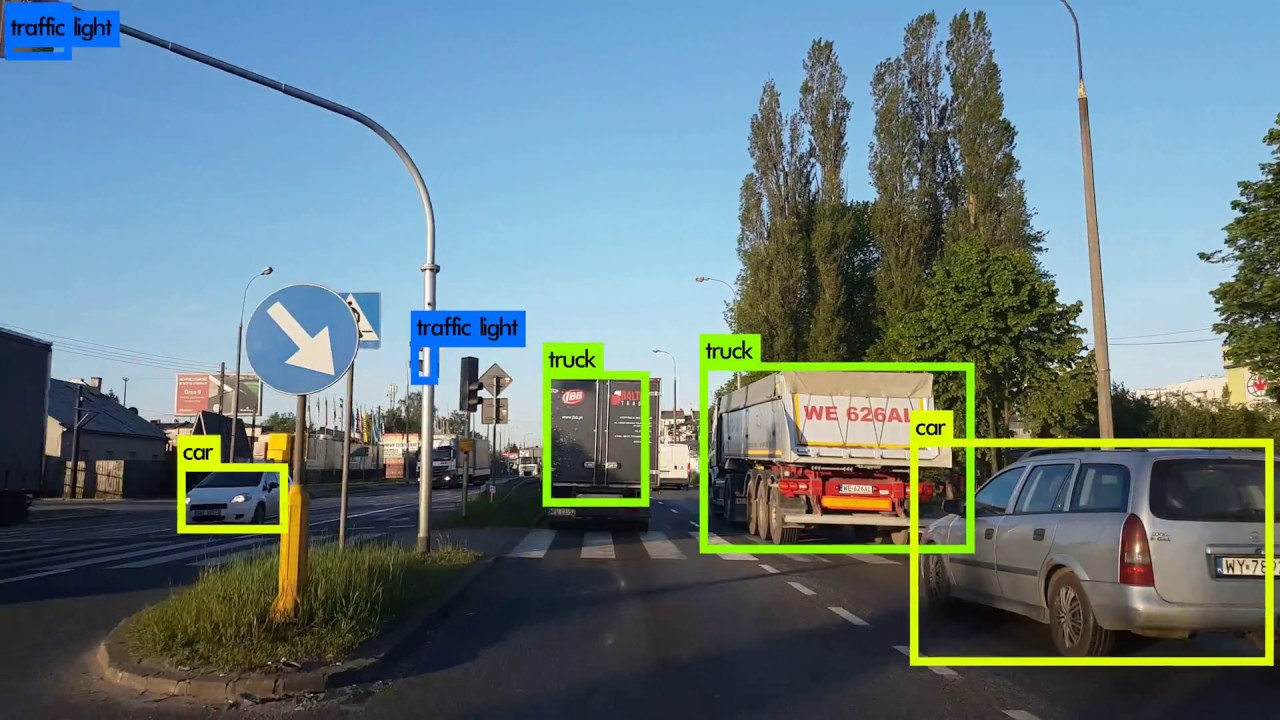

In [1]:
from IPython.display import Image
file_name1 = './img/ob1.jpg'
Image(file_name1)

Object detection is the process of identifying and localizing objects in an image. A typical object detection solution takes in an image as input and provides a bounding box on the image where a object of interest is along with identifying what object the box encapsulates. But before we have this solution, we need to acquire and process a traning dataset, create and setup a training job for the alorithm so that the aglorithm can learn about the dataset and then host the algorithm as an endpoint, to which we can supply the query image.

In [1]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import time
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import boto3
import botocore
from botocore.exceptions import ClientError

import csv
import io
import re
import s3fs
import mxnet as mx
import seaborn as sns
import pickle
import gzip
import urllib
import csv


import sagemaker                                 
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

### 1. Preparation (Specifying Sagemaker roles)

In [2]:
sess   = sagemaker.Session()
bucket = sess.default_bucket()                     
prefix = 'objectdetection'
region = boto3.Session().region_name
role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name

print('Sagemaker session :', sess)
print('S3 bucket :', bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x000001B0AE2EDF48>
S3 bucket : sagemaker-us-west-2-570447867175
Prefix : objectdetection
Region selected : us-west-2
IAM role : arn:aws:iam::570447867175:role/SageMakerNotebookRole


In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(region, 'object-detection', repo_version="latest")
print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


433757028032.dkr.ecr.us-west-2.amazonaws.com/object-detection:latest


### 2. Load Data

Dataset can be directly donwloaded from Pascal VOC website [Link](http://host.robots.ox.ac.uk/pascal/VOC/) 

In [4]:
# Download and Extract the dataset
# !wget -P /tmp http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
# !wget -P /tmp http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
# !wget -P /tmp http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

!tar -xf ./data/VOCtrainval_11-May-2012.tar && rm ./data/VOCtrainval_11-May-2012.tar
!tar -xf ./data/VOCtrainval_06-Nov-2007.tar && rm ./data/VOCtrainval_06-Nov-2007.tar
!tar -xf ./data/VOCtest_06-Nov-2007.tar && rm ./data/VOCtest_06-Nov-2007.tar

'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


##### Convert data into RecordIO format

RecordIO is a highly efficient binary data format from MXNet that makes it easy and simple to prepare the dataset and transfer to the instance that will run the training job. To generate a RecordIO file, we will use the tools from MXNet. The provided tools will first generate a list file and then use the im2rec tool to create the RecordIO file. More details on how to generate RecordIO file for object detection task, see the MXNet example.

For a detailed exaplantation of RecordIO format, go to [Link](https://mxnet.apache.org/api/faq/recordio)

##### We will combine the training and validation sets from both 2007 and 2012 as the training data set, and use the test set from 2007 as our validation set.

Tools (helper python files) that can directly generated the RecordIO files so that you do not need to do addtional work

In [ ]:
!python ./tools/prepare_dataset.py --dataset pascal --year 2007,2012 --set trainval --target ./VOCdevkit/train.lst
!rm -rf ./VOCdevkit/VOC2012
!python ./tools/prepare_dataset.py --dataset pascal --year 2007 --set test --target ./VOCdevkit/val.lst --no-shuffle
!rm -rf ./VOCdevkit/VOC2007

## Tip! (Convert Custom Datasets to RecordIO Formt)

In [7]:
###################### Convert datasets to RecordIO format ######################

Along with this notebook, we have provided tools that can directly generated the RecordIO files so that you do not need to do addtional work. These tools work with the Pascal datasets lst format, which is also quite the common among most datasets. If your data are stored in a different format or the annotation of your data is in a different format than the Pascal VOC dataset, you can also create the RecordIO by first generating the .lst file and then using the im2rec tool provided by MXNet. To make things clear, we will explain the definition of a .lst file so that you can prepare it in your own way. The following example is the first three lines of the .lst file we just generated for the Pascal VOC dataset.

In [8]:
# !head -n 3 VOCdevkit/train.lst > example.lst
# f = open('example.lst','r')
# lst_content = f.read()
# print(lst_content)

As can be seen that each line in the .lst file represents the annotations for a image. A .lst file is a tab-delimited file with multiple columns. The rows of the file are annotations of the of image files. The first column specifies a unique image index. The second column specifies the header size of the current row. In the above example .lst file, 2 from the second column means the second and third columns are header information, which will not be considered as label and bounding box information of the image specified by the current row.

The third column specifies the label width of a single object. In the first row of above sample .lst file, 5 from the third row means each object within an image will have 5 numbers to describe its label information, including class index, and bounding box coordinates. If there are multiple objects within one image, all the label information should be listed in one line. The annotation information for each object is represented as [class_index, xmin, ymin, xmax, ymax].

The classes should be labeled with successive numbers and start with 0. The bounding box coordinates are ratios of its top-left (xmin, ymin) and bottom-right (xmax, ymax) corner indices to the overall image size. Note that the top-left corner of the entire image is the origin (0, 0). The last column specifies the relative path of the image file.

After generating the .lst file, the RecordIO can be created by running the following command:

In [9]:
############################### End ################################

### 3. UpLoad Data to S3 

In [10]:
%%time

# Upload the RecordIO files to train and validation channels
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path='VOCdevkit/train.rec', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='VOCdevkit/val.rec', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

Wall time: 28min 10s


### 4. Create a Model

In [11]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 3600, #360000
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

The object detection algorithm at its core is the Single-Shot Multi-Box detection algorithm (SSD). This algorithm uses a base_network, which is typically a VGG or a ResNet. The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50 now. It also has a lot of options for hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Object Detection documentation for more details on the hyperparameters.

One of the hyperparameters here for instance is the epochs. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only 10 epochs. Based on our tests, train the model for 30 epochs with similar settings should give us reasonable detection results on the Pascal VOC data.

In [12]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=20,
                             mini_batch_size=32,
                             epochs=1,
                             learning_rate=0.001,
                             lr_scheduler_step='3,6',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=350,
                             num_training_samples=16551)

In [13]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

We have our Estimator object, we have set the hyperparameters for this object and we have our data channels linked with the algorithm. The only remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the Estimator classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm.

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as output_path in the estimator.

### 5. Start Training

In [14]:
%%time
od_model.fit(inputs=data_channels, logs=True)

2020-07-12 07:26:18 Starting - Starting the training job...
2020-07-12 07:26:20 Starting - Launching requested ML instances.........
2020-07-12 07:27:55 Starting - Preparing the instances for training...
2020-07-12 07:28:50 Downloading - Downloading input data......
2020-07-12 07:29:49 Training - Downloading the training image...
2020-07-12 07:30:32 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[07/12/2020 07:30:35 INFO 140215227627328] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'mome

### 6. Deploy the model

In [15]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.p2.xlarge')

-----------------!

### 7. Evaluating with the test set (Inference)

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. To do this, Let's download an image from PEXELS which the algorithm has so-far not seen.

In [ ]:
# !wget -O test.jpg https://images.pexels.com/photos/980382/pexels-photo-980382.jpeg

In [17]:
file_name = './img/test.jpeg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

Let us use our endpoint to try to detect objects within this image. Since the image is jpeg, we use the appropriate content_type to run the prediction job. The endpoint returns a JSON file that we can simply load and peek into.

In [18]:
object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
print(detections)

{'prediction': [[14.0, 0.2025546133518219, 0.7365995645523071, 0.5916425585746765, 0.7936760187149048, 0.7266425490379333], [14.0, 0.17821937799453735, 0.5254822373390198, 0.5507106781005859, 0.5797274708747864, 0.668736457824707], [14.0, 0.1693011224269867, 0.5267473459243774, 0.6437920928001404, 0.5833252668380737, 0.7695111632347107], [14.0, 0.16170768439769745, 0.5804219245910645, 0.6417412161827087, 0.635461688041687, 0.7767570614814758], [14.0, 0.16121160984039307, 0.41694602370262146, 0.6033470630645752, 0.4736211597919464, 0.7227576971054077], [14.0, 0.15900398790836334, 0.471711665391922, 0.6426763534545898, 0.5301546454429626, 0.7743848562240601], [14.0, 0.15881235897541046, 0.37294113636016846, 0.39656099677085876, 0.6308284997940063, 0.9767075777053833], [14.0, 0.15114277601242065, 0.18090635538101196, 0.41191601753234863, 0.4370630979537964, 0.97331702709198], [14.0, 0.1492079794406891, 0.5696930289268494, 0.6114770174026489, 0.7262446284294128, 0.8900072574615479], [14.0,

The results are in a format that is similar to the .lst format with an addition of a confidence score for each detected object. The format of the output can be represented as [class_index, confidence_score, xmin, ymin, xmax, ymax]. Typically, we don't consider low-confidence predictions.

We have provided additional script to easily visualize the detection outputs. You can visulize the high-confidence preditions with bounding box by filtering out low-confidence detections using the script below:

In [19]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

For this example, we trained the model with only 10 epochs. This implies that the results might not be optimal. To achieve better detection results, you can try to tune the hyperparameters and train the model for more epochs. In our tests, the mAP can reach 0.79 on the Pascal VOC dataset after training the algorithm with learning_rate=0.0005, image_shape=512 and mini_batch_size=16 for 240 epochs.

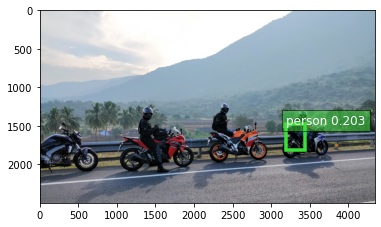

In [20]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
                     'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
                     'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.20

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

### 8. Close the SageMaker Instance

In [21]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)